In [75]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from skimage import img_as_ubyte
from skimage.feature import greycomatrix, greycoprops
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import rgb2gray, rgb2hsv, hsv2rgb
from sklearn.preprocessing import LabelEncoder
from PIL import Image

## 1. Feature Extraction 

Haralick Features

In [2]:
def extract_haralick_features(grayscale_image, args):
    distances = args['distances']
    angles = args['angles']
    glcm = greycomatrix(grayscale_image, distances, angles)
    features = [
        np.mean(greycoprops(glcm, 'contrast')),
        np.mean(greycoprops(glcm, 'dissimilarity')),
        np.mean(greycoprops(glcm, 'homogeneity')),
        np.mean(greycoprops(glcm, 'energy')),
        np.mean(greycoprops(glcm, 'correlation')),
        np.mean(greycoprops(glcm, 'ASM')),
    ]
    return features

def label_encode(y):
    le = LabelEncoder()
    le.fit(y)
    return (le.transform(y), le.classes_)

def get_dir_contents(path):
    cts = os.listdir(path)
    return [c for c in cts if c[0] != '.']

def get_X_y_vectors(path, feature_extraction_function, args):
    X = []
    y = []
    for label in get_dir_contents(path):
        for file_name in get_dir_contents(path + label + "/"):
            image = cv2.imread(path + label + "/" + file_name, cv2.IMREAD_GRAYSCALE)
            features = feature_extraction_function(image, args)
            X.append(features)
            y.append(label)
    y, classes_ = label_encode(y)
    return (np.array(X), y, classes_)

In [3]:
TRAIN_IMAGES_PATH = 'dataset/train/'
TEST_IMAGES_PATH = 'dataset/test/'

haralick_args = {
    'distances': [1], 
    'angles': [0, np.pi/4, np.pi/2, 3*np.pi/4]
}

X_train, y_train, train_classes_ = get_X_y_vectors(
    TRAIN_IMAGES_PATH, extract_haralick_features, haralick_args
)
X_test, y_test, test_classes_ = get_X_y_vectors(
    TEST_IMAGES_PATH, extract_haralick_features, haralick_args
)


print(f"X_train: {X_train.shape}\ty_train: {y_train.shape}")
print(f"X_test: {X_test.shape}\ty_test: {y_test.shape}")
print(f"Train classes: {train_classes_}\nTest classes: {test_classes_}")

X_train: (800, 6)	y_train: (800,)
X_test: (300, 6)	y_test: (300,)
Train classes: ['coast' 'dead_sargassum' 'sargassum' 'sky' 'water']
Test classes: ['coast' 'dead_sargassum' 'sargassum' 'sky' 'water']


## 2. Model Training and Evaluation

In [4]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
import pandas as pd

def evaluate(model, X_test, y_true, y_pred, target_names, model_name):
    print(f"----------—-------------—-------------—---{model_name}----------—-------------—-------------—---")
    print(classification_report(y_true, y_pred, target_names=target_names))
    plot_confusion_matrix(
        model, X_test, y_true, display_labels=target_names, cmap=plt.cm.Blues
    )
    plt.title(f"{model_name} confusion matrix")
    plt.show()

In [5]:
classifiers = [
    KNeighborsClassifier(n_neighbors=5, weights='distance'),
    SVC(),
    GaussianProcessClassifier(),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, max_features=5),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(random_state=0),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()
]
names = ["Nearest Neighbors", "SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Network", "AdaBoost",
         "Naive Bayes", "QDA"]

scores = []

for name, classifier in zip(names, classifiers):
    classifier.fit(X_train, y_train)
    score = classifier.score(X_test, y_test)
    y_pred = classifier.predict(X_test)
    scores.append(score)

df = pd.DataFrame({'classifier': names,'score': scores})
df = df.sort_values(by='score', ascending=False)
df

,classifier,score
4,Random Forest,0.690000
3,Decision Tree,0.636667
6,AdaBoost,0.616667
8,QDA,0.616667
2,Gaussian Process,0.603333
5,Neural Network,0.603333
0,Nearest Neighbors,0.573333
1,SVM,0.543333
7,Naive Bayes,0.493333


In [6]:
best_classifiers_df = df.iloc[:2]
for idx in np.array(best_classifiers_df.index):
    name = names[idx]
    clf = classifiers[idx]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"-------------------------{name}-------------------------")
    print(classification_report(y_test, y_pred, target_names=train_classes_))

-------------------------Random Forest-------------------------
                precision    recall  f1-score   support

         coast       0.79      0.97      0.87       116
dead_sargassum       0.68      0.33      0.45        45
     sargassum       0.59      0.32      0.41        53
           sky       0.88      0.76      0.81        29
         water       0.56      0.81      0.66        57

      accuracy                           0.71       300
     macro avg       0.70      0.64      0.64       300
  weighted avg       0.70      0.71      0.68       300

-------------------------Decision Tree-------------------------
                precision    recall  f1-score   support

         coast       0.76      0.96      0.85       116
dead_sargassum       0.47      0.18      0.26        45
     sargassum       0.29      0.13      0.18        53
           sky       0.84      0.72      0.78        29
         water       0.51      0.79      0.62        57

      accuracy             

In [7]:
best_classifiers_df = df.iloc[2:4]
for idx in np.array(best_classifiers_df.index):
    name = names[idx]
    clf = classifiers[idx]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"-------------------------{name}-------------------------")
    print(classification_report(y_test, y_pred, target_names=train_classes_))

-------------------------AdaBoost-------------------------
                precision    recall  f1-score   support

         coast       0.81      0.84      0.83       116
dead_sargassum       0.34      0.42      0.38        45
     sargassum       0.25      0.04      0.07        53
           sky       0.90      0.62      0.73        29
         water       0.51      0.84      0.63        57

      accuracy                           0.62       300
     macro avg       0.56      0.55      0.53       300
  weighted avg       0.59      0.62      0.58       300

-------------------------QDA-------------------------
                precision    recall  f1-score   support

         coast       0.99      0.59      0.74       116
dead_sargassum       0.44      0.89      0.59        45
     sargassum       0.38      0.11      0.17        53
           sky       0.75      0.72      0.74        29
         water       0.51      0.86      0.64        57

      accuracy                           0

In [8]:
random_forest = classifiers[3]
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)
print(f"-------------------------Random Forest-------------------------")
print(classification_report(y_test, y_pred, target_names=train_classes_))
y_pred.shape

-------------------------Random Forest-------------------------
                precision    recall  f1-score   support

         coast       0.76      0.96      0.84       116
dead_sargassum       0.47      0.18      0.26        45
     sargassum       0.29      0.13      0.18        53
           sky       0.84      0.72      0.78        29
         water       0.51      0.77      0.61        57

      accuracy                           0.64       300
     macro avg       0.57      0.55      0.53       300
  weighted avg       0.59      0.64      0.59       300



(300,)

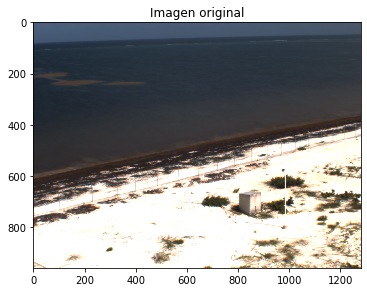

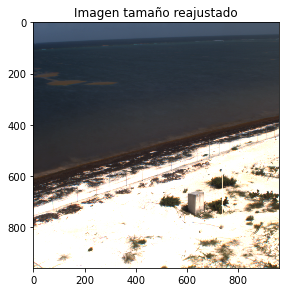

In [69]:
from image_splitting import split_image

img_file = 'imgs/2021-06-11/1623442800.Fri.Jun.11_20_20_00.GMT.2021.morelos.c2.timex.png'
img = imread(img_file)
imshow(img)
plt.title('Imagen original')
plt.show()
size = 960
img = resize(img, (960, 960))
imshow(img)
plt.title('Imagen tamaño reajustado')
plt.show()
num_window = 10
img_split = split_image(img, num_images=num_window**2)
# Conversión de los segmentos a escala de grises
img_split_gray = []
x =[]
for image in img_split:
    img_split_gray.append(img_as_ubyte(rgb2gray(image)))
    # Obtención de las características de Haralick
    features = extract_haralick_features(img_split_gray[-1], haralick_args)
    x.append(features)
x = np.array(x)

In [70]:
y_pred_img = random_forest.predict(x)
y_pred_img

array([3, 4, 4, 2, 2, 2, 0, 0, 0, 0, 3, 4, 4, 2, 1, 4, 0, 0, 0, 0, 3, 4,
       4, 2, 2, 1, 0, 0, 0, 0, 3, 4, 4, 2, 2, 1, 0, 0, 0, 0, 3, 4, 4, 2,
       4, 0, 0, 0, 0, 0, 3, 4, 4, 2, 4, 0, 0, 0, 0, 0, 3, 4, 4, 2, 1, 0,
       0, 0, 0, 0, 3, 2, 4, 2, 0, 0, 0, 0, 0, 0, 3, 2, 4, 2, 0, 0, 0, 0,
       0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0])

In [71]:
class_color = {
    0: (0 / 255, 63 / 255, 92 / 255),
    1: (88 / 255, 80 / 255, 141 / 255), 
    2: (188 / 255, 80 / 255, 144 / 255),
    3: (255 / 255, 99 / 255, 97 / 255), 
    4: (255 / 255, 166 / 255, 0 / 255)
}
img_split_color = img_split.copy()
for i in range(img_split.shape[0]):
    img_split_color[i, :, :] = class_color[y_pred_img[i]]
img_split

array([[[[0.32418301, 0.36862745, 0.4745098 ],
         [0.29607843, 0.36666667, 0.4745098 ],
         [0.29411765, 0.36470588, 0.47777778],
         ...,
         [0.30980392, 0.38104575, 0.47843137],
         [0.30980392, 0.38431373, 0.47843137],
         [0.30980392, 0.38104575, 0.48169935]],

        [[0.32026144, 0.36405229, 0.4745098 ],
         [0.29215686, 0.36078431, 0.4745098 ],
         [0.29019608, 0.36405229, 0.47777778],
         ...,
         [0.30196078, 0.37647059, 0.47843137],
         [0.30196078, 0.37647059, 0.47843137],
         [0.30196078, 0.37973856, 0.48169935]],

        [[0.32026144, 0.36078431, 0.46993464],
         [0.29215686, 0.36078431, 0.46666667],
         [0.29019608, 0.36078431, 0.46666667],
         ...,
         [0.30196078, 0.37254902, 0.4745098 ],
         [0.30196078, 0.37254902, 0.47647059],
         [0.30196078, 0.37254902, 0.47843137]],

        ...,

        [[0.14640523, 0.18823529, 0.25882353],
         [0.13333333, 0.18627451, 0.25882353]

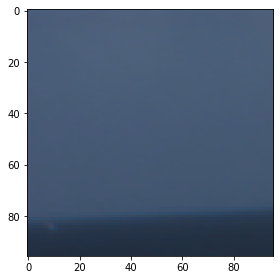

/Users/alejandro/opt/anaconda3/envs/py37/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


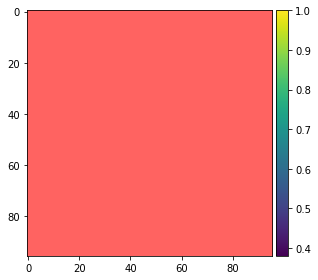

In [72]:
imshow(img_split[0])
plt.show()
imshow(img_split_color[0])
plt.show()

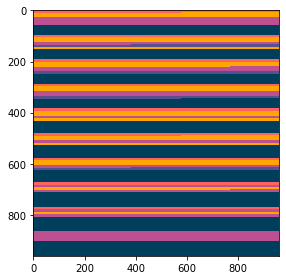

In [73]:
imshow(img_split_color.reshape(img.shape))
plt.show()

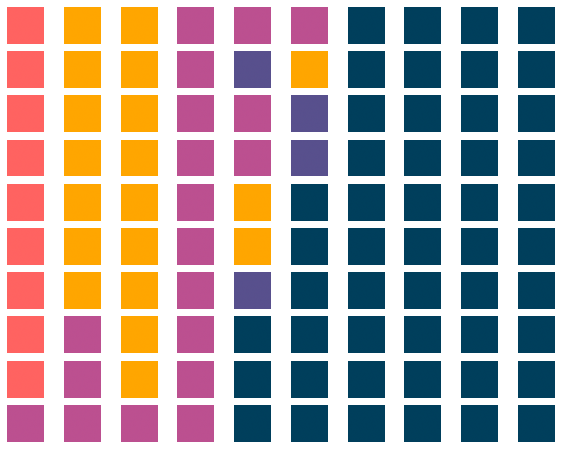

In [74]:
plt.figure(figsize=(10, 8))
for i in range(100):
    plt.subplot(10, 10, i + 1)
    plt.imshow(img_split_color[i])
    plt.axis('off')
plt.show()

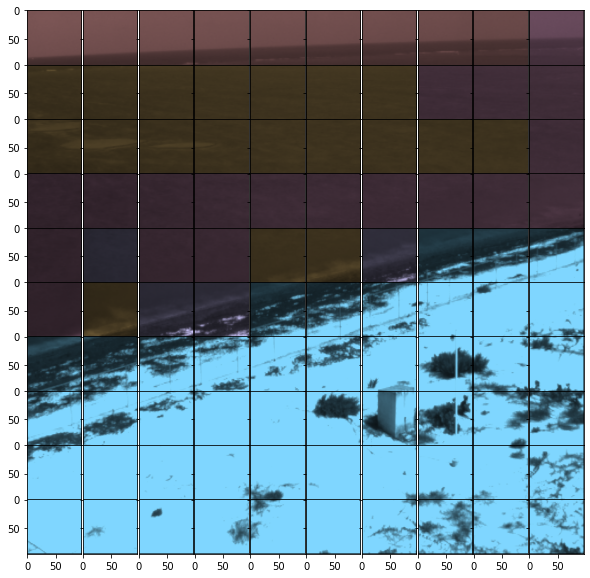

In [77]:
window_size = 10
alpha = 0.5
fig = plt.figure(figsize=(10,10))
gs = fig.add_gridspec(window_size, window_size, hspace=0, wspace=0)
axs = gs.subplots(sharex='col', sharey='row')
idx = 0 

# Desplegando la imagen
for i in range(window_size):
    for j in range(window_size):
        # Generando la máscara
        img_hsv = rgb2hsv(img_split[idx])
        color_mask_hsv = rgb2hsv(img_split_color[idx])
        img_hsv[..., 0] = color_mask_hsv[..., 0]
        img_hsv[..., 1] = color_mask_hsv[..., 1] * alpha
        img_mask = hsv2rgb(img_hsv)
        axs[j, i].imshow(img_mask)
        idx += 1

plt.show()